# Applying Naive Bayes 

In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
from collections import Counter

<h1>1. Data Reading and pre-processing if required</h1>

## 1.1 Loading Data

Here I have used data after pre-processing. Only essay text is not pre-processed.

In [7]:
import pandas
data = pandas.read_csv('C:/Users/rohin/AAIC/Git/donors_choose/preprocessed_data.csv', nrows=100000)
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [8]:
print(data['essay'].head(1).values)
#preprocessing is required for essays.

['i fortunate enough use fairy tale stem kits classroom well stem journals students really enjoyed i would love implement lakeshore stem kits classroom next school year provide excellent engaging stem lessons my students come variety backgrounds including language socioeconomic status many not lot experience science engineering kits give materials provide exciting opportunities students each month i try several science stem steam projects i would use kits robot help guide science instruction engaging meaningful ways i adapt kits current language arts pacing guide already teach material kits like tall tales paul bunyan johnny appleseed the following units taught next school year i implement kits magnets motion sink vs float robots i often get units not know if i teaching right way using right materials the kits give additional ideas strategies lessons prepare students science it challenging develop high quality science activities these kits give materials i need provide students science

<h3> Preprocessing essays</h3>

In [9]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [12]:
preprocessed_essays = preprocess_text(data['essay'].values)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:10<00:00, 767.51it/s]


In [13]:
data['preprocessed_essays'] = preprocessed_essays

In [14]:
#Afrer preprocessing the essays
print(data['preprocessed_essays'].head(1).values)

['fortunate enough use fairy tale stem kits classroom well stem journals students really enjoyed would love implement lakeshore stem kits classroom next school year provide excellent engaging stem lessons students come variety backgrounds including language socioeconomic status many not lot experience science engineering kits give materials provide exciting opportunities students month try several science stem steam projects would use kits robot help guide science instruction engaging meaningful ways adapt kits current language arts pacing guide already teach material kits like tall tales paul bunyan johnny appleseed following units taught next school year implement kits magnets motion sink vs float robots often get units not know teaching right way using right materials kits give additional ideas strategies lessons prepare students science challenging develop high quality science activities kits give materials need provide students science activities go along curriculum classroom alth

In [15]:
y = data['project_is_approved'].values #class label
X = data.drop(['project_is_approved'], axis=1) #data points
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,preprocessed_essays
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,fortunate enough use fairy tale stem kits clas...


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [16]:
#splitting data into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y)
print("x_train: ",x_train.shape)
print("x_test : ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test : ",y_test.shape)

x_train:  (80000, 9)
x_test :  (20000, 9)
y_train:  (80000,)
y_test :  (20000,)


<h2>1.3 Make Data Model Ready: encoding eassay</h2>


<h3>1.3.1 BOW:Encoding essays</h3>

In [17]:
vectorizer_essay_bow = CountVectorizer(min_df=10)
vectorizer_essay_bow.fit(x_train['preprocessed_essays'].values) # fit has to happen only on train data
#(min_df=10,ngram_range=(1,2), max_features=5000)
# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay_bow.transform(x_train['preprocessed_essays'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(x_test['preprocessed_essays'].values)

print("After vectorization")
print("Shape of matrix after BOW -> essays: x_train:",X_train_essay_bow.shape)
print("Shape of matrix after BOW -> essays: x_test:",X_test_essay_bow.shape )

After vectorization
Shape of matrix after BOW -> essays: x_train: (80000, 14585)
Shape of matrix after BOW -> essays: x_test: (20000, 14585)


<h3> 1.3.2 TF-IDF: Encoding essays</h3>

In [18]:
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
vectorizer_essay_tfidf.fit(x_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essay_tfidf.transform(x_train['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(x_test['preprocessed_essays'].values)

print("After vectorization")
print("Shape of matrix after TF-IDF -> essays: x_train:",X_train_essay_tfidf.shape)
print("Shape of matrix after TF-IDF -> essays: x_test:",X_test_essay_tfidf.shape )

After vectorization
Shape of matrix after TF-IDF -> essays: x_train: (80000, 14585)
Shape of matrix after TF-IDF -> essays: x_test: (20000, 14585)


<h2>1.4 Make Data Model Ready: encoding categorical, numerical features</h2>
<h3>1.4.1 encoding categorical features: School State</h3>

In [19]:
vectorizer_school_state = CountVectorizer()
vectorizer_school_state.fit(x_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_school_state.transform(x_train['school_state'].values)
X_test_state_ohe = vectorizer_school_state.transform(x_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())
print("="*100)

After vectorizations
(80000, 51) (80000,)
(20000, 51) (20000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [20]:
vectorizer_prefix = CountVectorizer()
vectorizer_prefix.fit(x_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_prefix.transform(x_train['teacher_prefix'].values)
#X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_prefix.transform(x_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
#print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_prefix.get_feature_names())
print("="*100)

After vectorizations
(80000, 5) (80000,)
(20000, 5) (20000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [21]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(x_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade.transform(x_train['project_grade_category'].values)
#X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(x_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
#print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer_grade.get_feature_names())
print("="*100)

After vectorizations
(80000, 4) (80000,)
(20000, 4) (20000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>1.4.4 Vectorizing Categorical data: clean categories</h3>

In [22]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
print(sorted_cat_dict)


{'warmth': 1119, 'care_hunger': 1119, 'history_civics': 5445, 'music_arts': 9469, 'appliedlearning': 10837, 'specialneeds': 12392, 'health_sports': 13422, 'math_science': 38007, 'literacy_language': 47896}


In [23]:
vectorizer_cat = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_cat.fit(x_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_one_hot = vectorizer_cat.transform(x_train['clean_categories'].values)
#X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_categories_one_hot = vectorizer_cat.transform(x_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_one_hot.shape, y_train.shape)
#print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_categories_one_hot.shape, y_test.shape)
print(vectorizer_cat.get_feature_names())
print("="*100)

After vectorizations
(80000, 9) (80000,)
(20000, 9) (20000,)
['warmth', 'care_hunger', 'history_civics', 'music_arts', 'appliedlearning', 'specialneeds', 'health_sports', 'math_science', 'literacy_language']


<h3>1.4.5 Vectorizing Categorical data: clean subcategories</h3>

In [24]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in data['clean_subcategories'].values:
    my_counter.update(word.split())

sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))
print(sorted_sub_cat_dict)


{'economics': 255, 'communityservice': 407, 'financialliteracy': 491, 'parentinvolvement': 605, 'extracurricular': 713, 'civics_government': 763, 'foreignlanguages': 822, 'warmth': 1119, 'care_hunger': 1119, 'nutritioneducation': 1323, 'socialsciences': 1784, 'performingarts': 1791, 'charactereducation': 1881, 'teamsports': 1950, 'other': 2119, 'college_careerprep': 2332, 'music': 2888, 'history_geography': 2921, 'earlydevelopment': 3719, 'health_lifescience': 3899, 'esl': 4007, 'gym_fitness': 4240, 'environmentalscience': 5104, 'visualarts': 5791, 'health_wellness': 9816, 'appliedsciences': 9847, 'specialneeds': 12392, 'literature_writing': 20387, 'mathematics': 25830, 'literacy': 30836}


In [25]:
vectorizer_sub = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer_sub.fit(x_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_categories_one_hot = vectorizer_sub.transform(x_train['clean_subcategories'].values)
#X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_sub_categories_one_hot = vectorizer_sub.transform(x_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_sub_categories_one_hot.shape, y_train.shape)
#print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_sub_categories_one_hot.shape, y_test.shape)
print(vectorizer_sub.get_feature_names())
print("="*100)

After vectorizations
(80000, 30) (80000,)
(20000, 30) (20000,)
['economics', 'communityservice', 'financialliteracy', 'parentinvolvement', 'extracurricular', 'civics_government', 'foreignlanguages', 'warmth', 'care_hunger', 'nutritioneducation', 'socialsciences', 'performingarts', 'charactereducation', 'teamsports', 'other', 'college_careerprep', 'music', 'history_geography', 'earlydevelopment', 'health_lifescience', 'esl', 'gym_fitness', 'environmentalscience', 'visualarts', 'health_wellness', 'appliedsciences', 'specialneeds', 'literature_writing', 'mathematics', 'literacy']


<h3>1.4.6 Normalizing numerical data: price</h3>

In [26]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(x_train['price'].values.reshape(1,-1))
# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
X_train_price_normalized = normalizer.transform(x_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_normalized = normalizer.transform(x_test['price'].values.reshape(1,-1)).reshape(-1,1)



print("After Normalizing")
print(X_train_price_normalized.shape, y_train.shape)
#print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_normalized.shape, y_test.shape)
print("="*100)

After Normalizing
(80000, 1) (80000,)
(20000, 1) (20000,)


In [27]:
X_train_price_normalized

array([[0.00409842],
       [0.00027308],
       [0.00099101],
       ...,
       [0.00039012],
       [0.00359052],
       [0.00060126]])

<h3>1.4.7  Normalizing Numerical data:teacher_number_of_previously_posted_projects</h3>

In [28]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_previous_proj_normalized = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
#X_cv_teacher_previous_proj_normalized= normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_teacher_previous_proj_normalized = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
X_train_teacher_previous_proj_normalized = X_train_teacher_previous_proj_normalized.reshape(-1, 1)

X_test_teacher_previous_proj_normalized = X_test_teacher_previous_proj_normalized.reshape(-1, 1)


print("After Normalizing")
print(X_train_teacher_previous_proj_normalized.shape, y_train.shape)
#print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_teacher_previous_proj_normalized.shape, y_test.shape)


After Normalizing
(80000, 1) (80000,)
(20000, 1) (20000,)


In [29]:
X_train_teacher_previous_proj_normalized

array([[0.00122075],
       [0.00012207],
       [0.00292979],
       ...,
       [0.        ],
       [0.        ],
       [0.00024415]])

<h2>1.5 Merging Features</h2>
<h3>1.5.1 Merging all one hot features

In [30]:
from scipy.sparse import hstack
x_train_one_hot = hstack((
    X_train_state_ohe,
    X_train_teacher_ohe,
    X_train_grade_ohe,
    X_train_categories_one_hot,
    X_train_sub_categories_one_hot,
    X_train_price_normalized,
    X_train_teacher_previous_proj_normalized))

x_test_one_hot = hstack((
    X_test_state_ohe,
    X_test_teacher_ohe,
    X_test_grade_ohe,
    X_test_categories_one_hot,
    X_test_sub_categories_one_hot,
    X_test_price_normalized,
    X_test_teacher_previous_proj_normalized))
print("Type of x_train_one_hot:",type(x_train_one_hot))
print("Type of x_test_one_hot:",type(x_test_one_hot))
print("Shape of x_train_one_hot:",x_train_one_hot.shape)
print("Shape of x_test_one_hot:",x_test_one_hot.shape)

Type of x_train_one_hot: <class 'scipy.sparse.coo.coo_matrix'>
Type of x_test_one_hot: <class 'scipy.sparse.coo.coo_matrix'>
Shape of x_train_one_hot: (80000, 101)
Shape of x_test_one_hot: (20000, 101)


<h3>1.5.2 Set 1: categorical, numerical features + preprocessed_eassay (BOW)</h3>

In [31]:
x_train_one_hot_bow = hstack((x_train_one_hot, X_train_essay_bow)).tocsr()
x_test_one_hot_bow = hstack((x_test_one_hot, X_test_essay_bow)).tocsr()

print("Type of x_train_one_hot_bow:",type(x_train_one_hot_bow))
print("Type of x_test_one_hot_bow:",type(x_test_one_hot_bow))
print("Shape of x_train_one_hot_bow:",x_train_one_hot_bow.shape)
print("Shape of x_test_one_hot_bow:",x_test_one_hot_bow.shape)


Type of x_train_one_hot_bow: <class 'scipy.sparse.csr.csr_matrix'>
Type of x_test_one_hot_bow: <class 'scipy.sparse.csr.csr_matrix'>
Shape of x_train_one_hot_bow: (80000, 14686)
Shape of x_test_one_hot_bow: (20000, 14686)


<h3>1.5.3 Set 2: categorical, numerical features + preprocessed_eassay (TF-IDF)</h3>

In [32]:
x_train_one_hot_tfidf = hstack((x_train_one_hot, X_train_essay_tfidf)).tocsr()
x_test_one_hot_tfidf = hstack((x_test_one_hot, X_test_essay_tfidf)).tocsr()

print("Type of x_train_one_hot_tfidf:",type(x_train_one_hot_tfidf))
print("Type of x_test_one_hot_tfidf:",type(x_test_one_hot_tfidf))
print("Shape of x_train_one_hot_tfidf:",x_train_one_hot_tfidf.shape)
print("Shape of x_test_one_hot_tfidf:",x_test_one_hot_tfidf.shape)


Type of x_train_one_hot_tfidf: <class 'scipy.sparse.csr.csr_matrix'>
Type of x_test_one_hot_tfidf: <class 'scipy.sparse.csr.csr_matrix'>
Shape of x_train_one_hot_tfidf: (80000, 14686)
Shape of x_test_one_hot_tfidf: (20000, 14686)


<h2>1.6 SET1: Appling NB on BOW</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

<h3>1.6.1 SET1: The hyper paramter tuning(find best alpha:smoothing parameter) using GRIDSEARCHCV</h3>

In [33]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

from sklearn.model_selection import GridSearchCV
mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_bow, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
# clf.fit(x_cv_onehot_bow, y_cv)
clf.fit(x_train_one_hot_bow,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_1=clf.best_params_['alpha']
bestScore_1=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_) #clf.best_estimator_.alpha

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BEST ALPHA:  0.5  BEST SCORE:  0.7026079612135183


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 12103.03it/s]


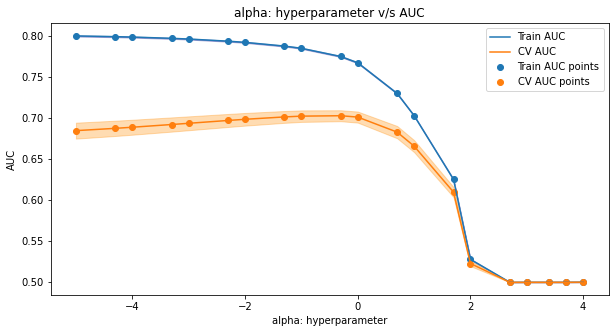

In [34]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
#     b = math.log(a)
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
#plt.grid()
plt.show()

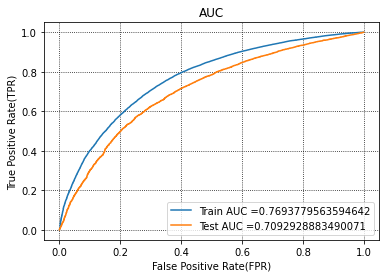

In [35]:
#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
mnb_bow_testModel = MultinomialNB(alpha = bestAlpha_1,class_prior=[0.5, 0.5])
mnb_bow_testModel.fit(x_train_one_hot_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_bow_testModel, x_train_onehot_bow)
y_train_pred=mnb_bow_testModel.predict_proba(x_train_one_hot_bow)[:,1]
# y_test_pred = batch_predict(mnb_bow_testModel, x_test_onehot_bow)
y_test_pred=mnb_bow_testModel.predict_proba(x_test_one_hot_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<h3> SET1: Confusion Matrix: Train</h3>

In [36]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.49456890061186626 for threshold 0.396
[[ 8276  3870]
 [18603 49251]]
the maximum value of tpr*(1-fpr) 0.49456890061186626 for threshold 0.396


<AxesSubplot:>

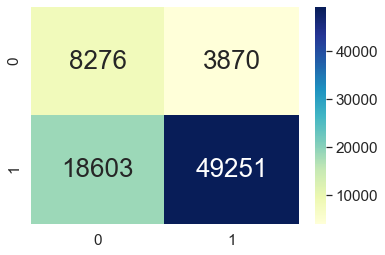

In [37]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

<h3>SET1: Confusion Matrix: Test</h3>

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.4375666568724186 for threshold 0.997
[[ 2744   293]
 [12019  4944]]
the maximum value of tpr*(1-fpr) 0.4375666568724186 for threshold 0.997


<AxesSubplot:>

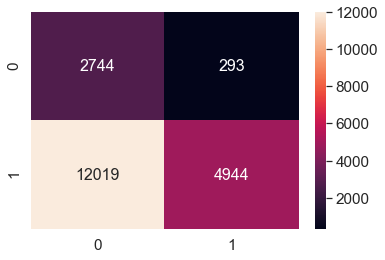

In [38]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

<h2>1.7 SET2: Applying naive bayes on TFIDF</h2>

<h3>1.7.1 SET2: Hyerparameter tuning to find the best aalpha using GRIDSEARCHCV</h3>


In [39]:
from sklearn.model_selection import GridSearchCV
mnb_tfidf = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}
clf = GridSearchCV(mnb_tfidf, parameters, cv= 10, scoring='roc_auc',verbose=1,return_train_score=True)
# clf.fit(x_cv_onehot_tfidf, y_cv)
clf.fit(x_train_one_hot_tfidf,y_train)
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestAlpha_2=clf.best_params_['alpha']
bestScore_2=clf.best_score_
print("BEST ALPHA: ",clf.best_params_['alpha']," BEST SCORE: ",clf.best_score_) 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


BEST ALPHA:  0.05  BEST SCORE:  0.677894450374866


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.3min finished


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<?, ?it/s]


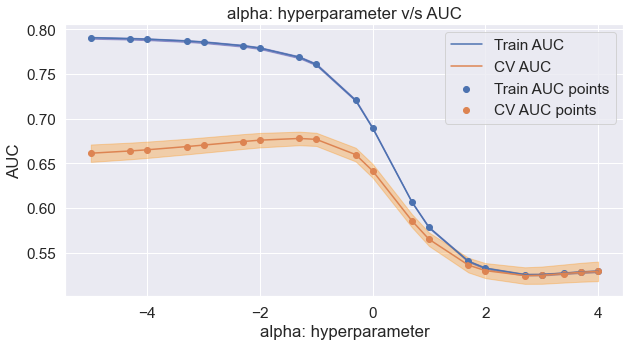

In [40]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]
log_alphas =[]
for a in tqdm(alphas):
#     b = math.log(a)
    b = np.log10(a)
    log_alphas.append(b)
plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")

plt.show() 

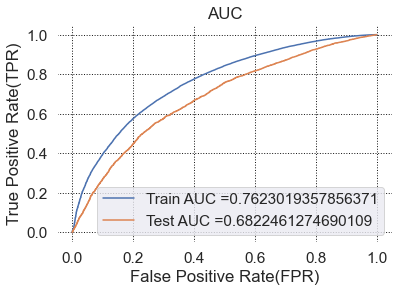

In [41]:
from sklearn.metrics import roc_curve, auc
mnb_tfidf_testModel = MultinomialNB(alpha = bestAlpha_2,class_prior=[0.5, 0.5])
mnb_tfidf_testModel.fit(x_train_one_hot_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_tfidf_testModel, x_train_onehot_tfidf)
# y_test_pred = batch_predict(mnb_tfidf_testModel, x_test_onehot_tfidf)
y_train_pred=mnb_tfidf_testModel.predict_proba(x_train_one_hot_tfidf)[:,1]
y_test_pred=mnb_tfidf_testModel.predict_proba(x_test_one_hot_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()

auc_set2_train=auc(train_fpr, train_tpr)
auc_set2_test=auc(test_fpr, test_tpr)

# plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
# plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

<h3>SET2: Confusion Matrix: Train</h3>

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.48199476471094105 for threshold 0.515
[[ 8777  3369]
 [22595 45259]]
the maximum value of tpr*(1-fpr) 0.48199476471094105 for threshold 0.515


<AxesSubplot:>

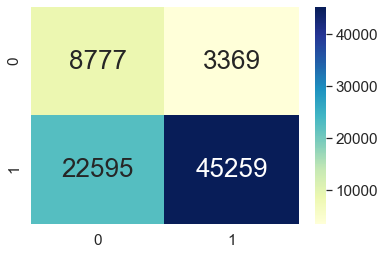

In [42]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))

## Heatmaps -> https://likegeeks.com/seaborn-heatmap-tutorial/
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 26}, fmt='g',cmap="YlGnBu")

<h3>SET2: Confusion Matrix: Test</h3>

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.4066256390096627 for threshold 0.659
[[ 2675   362]
 [11733  5230]]
the maximum value of tpr*(1-fpr) 0.4066256390096627 for threshold 0.659


<AxesSubplot:>

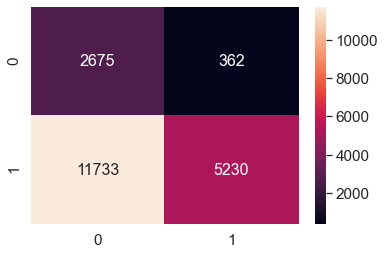

In [43]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 16}, fmt='g')

<h2>1.8 TOP 20 FEATURES FOR SET1: BOW</h2>



In [44]:
#top 20 important features-BOW: https://medium.com/analytics-vidhya/naive-bayes-with-bag-of-words-on-kaggle-donor-choose-dataset-117573335b6c
# using feature_log_prob_ to get the most important features
print('mnb_bow_testModel.feature_log_prob_ \n', mnb_bow_testModel.feature_log_prob_)
# Its basically, just the log probability of each word, given in a 2-d array structure
# Note, feature_log_prob_ will give me the actual log probabilities of each features,
# but I need the index position of those probabilities.
# So, that with that same index position I can get the corresponding feature-names.
print("="*100)
print('LEN of mnb_bow_testModel.feature_log_prob_ ', len(mnb_bow_testModel.feature_log_prob_[1]))

# So, first, I will sort the result from feature_log_prob_ , and ONLY after that
# get the corresponding positional-index of the top 20 features.
# And then I can apply the same positional-index number to get the corresponding features names (which are the labels / words )
# https://stackoverflow.com/a/50530697/1902852

probabilities_sorted_of_all_negative_class = mnb_bow_testModel.feature_log_prob_[0, :].argsort()
#class 0

positive_class_sorted_proba = mnb_bow_testModel.feature_log_prob_[1, :].argsort()
#class 1

'''numpy.argsort() function is used to perform an indirect sort along the given axis. It returns an array of indices of the same shape as arr that that would sort the array. Basically it gives me the sorted array indices'''

print("Shape of probabilities_sorted_of_all_negative_class ", probabilities_sorted_of_all_negative_class.shape)
print("Shape of positive_class_sorted_proba ", positive_class_sorted_proba.shape)

# Now - Lets get all horizontally stacked features which were individually derived from CounterVectorizer earlier
# Using itertools.chain() method to chain multiple arrays/lists at once
# https://stackoverflow.com/a/34665782/1902852
from itertools import chain

vectorized_all_features_horizontally_stacked = list(chain(vectorizer_cat.get_feature_names(), 
                                                          vectorizer_sub.get_feature_names(), 
                                                          vectorizer_prefix.get_feature_names(),  
                                                          vectorizer_grade.get_feature_names(), 
                                                          vectorizer_school_state.get_feature_names(), 
                                                          vectorizer_essay_bow.get_feature_names()))

# After adding all the vectorized features (which includes both categorical and text features)
# And now I also need to append the two left-over Numerical features which are
# 'price' and 'teacher_number_of_previously_posted_projects'
vectorized_all_features_horizontally_stacked.extend(['price', 'teacher_number_of_previously_posted_projects'])

# The above extend() is equivalent to below append()
# vectorized_all_features_horizontally_stacked.append('resource_cost')
# vectorized_all_features_horizontally_stacked.append('teacher_number_of_previously_posted_projects' )

print('Length of vectorized_all_features_horizontally_stacked', ' ( should be ', x_train_one_hot_bow.shape[1], ') : ' , len(vectorized_all_features_horizontally_stacked))



mnb_bow_testModel.feature_log_prob_ 
 [[-10.69624551  -9.11933079  -9.38252184 ... -13.06782347 -13.06782347
  -12.81650905]
 [-10.75262682  -9.1009291   -9.62875668 ... -13.74119061 -12.97905055
  -12.25311355]]
LEN of mnb_bow_testModel.feature_log_prob_  14686
Shape of probabilities_sorted_of_all_negative_class  (14686,)
Shape of positive_class_sorted_proba  (14686,)
Length of vectorized_all_features_horizontally_stacked  ( should be  14686 ) :  14686


<h3>SET1: NEGATIVE CLASS </h3>

In [45]:
# FINALLY THE TOP 20 FEATURES
top_20_negative_class_features_labels = np.take(vectorized_all_features_horizontally_stacked, probabilities_sorted_of_all_negative_class[-20: -1])
print('top_20_negative_class_features_labels:\n ', top_20_negative_class_features_labels)

top_20_negative_class_features_labels:
  ['classes' 'daylight' 'used' 'math' 'skip' 'abound' 'loved' 'reads'
 'comedians' 'workbook' 'neediest' 'maple' 'napkins' 'helper' 'learner'
 'notable' 'classwork' 'learniture' 'schooler']


<h3>SET1: POSITIVE CLASS </h3>

In [46]:

top_20_positive_class_features_labels = np.take(vectorized_all_features_horizontally_stacked, positive_class_sorted_proba[-20: -1])
print('top_20_positive_class_features_labels:\n ', top_20_positive_class_features_labels)


top_20_positive_class_features_labels:
  ['techy' 'woven' 'classes' 'comedians' 'daylight' 'abound' 'loved' 'used'
 'neediest' 'workbook' 'reads' 'napkins' 'maple' 'helper' 'learner'
 'notable' 'classwork' 'learniture' 'schooler']


<h2>1.9 CONCLUSION </h2>

In [47]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter: Alpha", "Train AUC", "Test AUC"]
auc_set2_train=auc(train_fpr, train_tpr)
auc_set2_test=auc(test_fpr, test_tpr)

x.add_row(["BOW", "Multinomial Naive Bayes", bestAlpha_1, round(auc_set1_train,2),round(auc_set1_test,2)])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", bestAlpha_2, round(auc_set2_train,2),round(auc_set2_test,2)])

print(x)

+------------+-------------------------+-----------------------+-----------+----------+
| Vectorizer |          Model          | Hyperparameter: Alpha | Train AUC | Test AUC |
+------------+-------------------------+-----------------------+-----------+----------+
|    BOW     | Multinomial Naive Bayes |          0.5          |    0.77   |   0.71   |
|   TF-IDF   | Multinomial Naive Bayes |          0.05         |    0.76   |   0.68   |
+------------+-------------------------+-----------------------+-----------+----------+


<h2>References:</h2>

* https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset

* https://medium.com/analytics-vidhya/naive-bayes-with-bag-of-words-on-kaggle-donor-choose-dataset-117573335b6c

* https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course